In [1]:
import json
import os
import sys

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gc_utils import iteration_name, snapshot_name  # type: ignore
from scipy.interpolate import PchipInterpolator, interp1d

Lets first make a plot that shows the mass of Ex-situ formed GCs

In [2]:
def get_type_flag(gc, grp, gc_survive_lst):
    if gc in gc_survive_lst:
        if grp == 0:
            # formed in-situ and survived to z = 0
            type_flag = 0
        elif grp > 0:
            # formed ex-situ, accreted and survived to z = 0
            type_flag = 2

    elif grp < -2:
        # formed ex-situ and died before accretion
        type_flag = 4

    elif grp > 0:
        # formed ex-situ, accreted but died before z = 0
        type_flag = 3

    elif grp == 0:
        # formed in-situ, but died before z = 0
        type_flag = 1

    else:
        sys.exit("Some GC Missing Type Flag")

    return type_flag

In [14]:
def get_mass_data(it, evolve_mass_loss, sim, sim_dir, save_dir, save_dict=True, return_dict=False):
    # get required files

    proc_file = sim_dir + sim + "/" + sim + "_processed.hdf5"
    proc_data = h5py.File(proc_file, "r")  # open processed data file

    pub_data = sim_dir + "snapshot_times_public.txt"
    pub_snaps = pd.read_table(pub_data, comment="#", header=None, sep=r"\s+")
    pub_snaps.columns = [
        "index",
        "scale_factor",
        "redshift",
        "time_Gyr",
        "lookback_time_Gyr",
        "time_width_Myr",
    ]

    mass_dict = {}

    it_id = iteration_name(it)
    mass_dict[it_id] = {}

    src_dat = proc_data[it_id]["source"]
    ana_mask = np.array(src_dat["analyse_flag"]) == 1

    gc_lst = np.array(src_dat["gc_id"])[ana_mask]
    gc_survive_lst = np.array(proc_data[it_id]["snapshots"]["snap600"]["gc_id"])

    for gc in gc_lst:
        gc_id = str(gc)
        mass_dict[it_id][gc_id] = {}

        idx = np.where(np.array(src_dat["gc_id"])[ana_mask] == gc)[0][0]
        grp = np.array(src_dat["group_id"])[ana_mask][idx]

        mass_dict[it_id][gc_id]["group_id"] = int(grp)
        mass_dict[it_id][gc_id]["type_flag"] = get_type_flag(gc, grp, gc_survive_lst)

        time_lst = []
        time_for_lst = []

        log_mass_lst = []  # mass at each time
        mass_loss_lst = []  # mass loss
        mass_loss_det_lst = []  # mass loss but taking t_form as 55% of t_form

        # get formation information
        t_form = np.array(src_dat["form_time"])[ana_mask][idx]

        log_mass_form = np.array(src_dat["logm_tform"])[ana_mask][idx]
        log_mass_form_det = (
            np.log10(1 - evolve_mass_loss) + log_mass_form
        )  # corrected for mass loss by evolution

        # get other details
        t_dis = np.array(src_dat["t_dis"])[ana_mask][idx]

        # update relevant lists
        time_lst.append(t_form)
        time_for_lst.append(t_form - t_form)

        # only for accreted (types 2, 3, 4) GCs
        if mass_dict[it_id][gc_id]["type_flag"] > 1:
            time_acc_lst = []

            t_acc = np.array(src_dat["t_acc"])[ana_mask][idx]
            time_acc_lst.append(t_form - t_acc)

        log_mass_lst.append(log_mass_form)

        # add mass loss as 0 for first time step
        mass_loss_lst.append(0)
        mass_loss_det_lst.append(0)

        if t_dis == -1:
            snap_lst = pub_snaps[(pub_snaps["time_Gyr"] >= t_form)]["index"]
        else:
            snap_lst = pub_snaps[(pub_snaps["time_Gyr"] >= t_form) & (pub_snaps["time_Gyr"] <= t_dis)][
                "index"
            ]

        # this has been added to ensure that GCs that form and die between snaps are considered in the for loop
        # that gets the details of their death (death loop)
        time = t_form

        for snap in snap_lst:
            snap_id = snapshot_name(snap)
            snap_dat = proc_data[it_id]["snapshots"][snap_id]

            # check, sometimes timing issues with GC formation model
            gc_snap_lst = np.array(snap_dat["gc_id"])
            if gc not in gc_snap_lst:
                continue

            time = pub_snaps[pub_snaps["index"] == snap]["time_Gyr"].values[0]

            snap_idx = np.where(np.array(snap_dat["gc_id"]) == gc)[0][0]
            cur_log_mass = np.array(snap_dat["mass"])[snap_idx]

            pst_log_mass = log_mass_lst[-1]
            pst_mass = 10**pst_log_mass

            cur_mass = 10**cur_log_mass

            # get mass loss (not logged)
            mass_los = pst_mass - cur_mass

            # make initial correction to detectable mass loss list
            if len(log_mass_lst) == 1:
                mass_form_det = 10**log_mass_form_det
                mass_los_det = mass_form_det - cur_mass
            else:
                mass_los_det = mass_los

            # update relevant lists
            log_mass_lst.append(cur_log_mass)

            mass_loss_lst.append(mass_los)
            mass_loss_det_lst.append(mass_los_det)

            time_lst.append(time)
            time_for_lst.append(time - t_form)

            # get accretion time
            if mass_dict[it_id][gc_id]["type_flag"] > 1:
                time_acc_lst.append(time - t_acc)

        # need to consider full disruption stuff too
        # like if in past list but not in current list mass loss is 100%

        # (death loop)
        # update full disruption details fro GCs that don't survive to z = 0

        # if (mass_dict[it_id][gc]["type_flag"] != 0) and (mass_dict[it_id][gc]["type_flag"] != 2):
        #     last_time = pub_snaps[pub_snaps["time_Gyr"] > time]["time_Gyr"].values[0]

        if t_dis != -1:
            # no longer exists
            # final_log_mass = np.nan
            final_log_mass = None

            # past mass
            pst_log_mass = log_mass_lst[-1]
            pst_mass = 10**pst_log_mass

            # as fully disrupted
            mass_los = pst_mass

            time_lst.append(t_dis)
            time_for_lst.append(t_dis - t_form)

            # get accretion time
            if mass_dict[it_id][gc_id]["type_flag"] > 1:
                time_acc_lst.append(t_dis - t_acc)

            log_mass_lst.append(final_log_mass)
            mass_loss_lst.append(mass_los)
            mass_loss_det_lst.append(mass_los)

        # update dictionary
        mass_dict[it_id][gc_id]["time"] = time_lst
        mass_dict[it_id][gc_id]["form_time"] = time_for_lst

        if mass_dict[it_id][gc_id]["type_flag"] > 1:
            mass_dict[it_id][gc_id]["acc_time"] = time_acc_lst

        mass_dict[it_id][gc_id]["log_mass"] = log_mass_lst
        mass_dict[it_id][gc_id]["mass_loss"] = mass_loss_lst
        mass_dict[it_id][gc_id]["mass_loss_detectable"] = mass_loss_det_lst

    # close file
    proc_data.close()

    if save_dict:
        save_file = save_dir + "/" + it_id + "_gc_mass_data.json"

        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        with open(save_file, "w") as f:
            json.dump(mass_dict, f, indent=4)  # `indent=4` makes it more readable

    if return_dict:
        return mass_dict

In [4]:
# Save to a JSON file
evolve_mass_loss = 0.45

it_min = 0
it_max = 0
# it_max = 100

sim = "m12i"

sim_dir = "/Users/z5114326/Documents/simulations/"
save_dir = "../data/gc_mass_data/" + sim

In [5]:
for it in range(it_min, it_max + 1):
    get_mass_data(it, evolve_mass_loss, sim, sim_dir, save_dir, save_dict=True, return_dict=False)

# Lets plot

In [6]:
it = 0

it_id = iteration_name(it)

data_file = save_dir + "/" + it_id + "_gc_mass_data.json"

# open json file as dict
with open(data_file, "r") as file:
    mass_dict = json.load(file)

Create interim dictionary

In [58]:
interim_dict = {}

interim_dict[it_id] = {}

interim_dict[it_id]["0"] = {}
interim_dict[it_id]["1"] = {}
interim_dict[it_id]["2"] = {}
interim_dict[it_id]["3"] = {}
interim_dict[it_id]["4"] = {}

# set up dictionary
for type_flag in range(0, 5):
    interim_dict[it_id][str(type_flag)] = {}

    interim_dict[it_id][str(type_flag)]["time"] = []
    interim_dict[it_id][str(type_flag)]["form_time"] = []

    interim_dict[it_id][str(type_flag)]["mass"] = []
    interim_dict[it_id][str(type_flag)]["mass_loss"] = []
    interim_dict[it_id][str(type_flag)]["mass_loss_det"] = []

    if type_flag > 1:
        interim_dict[it_id][str(type_flag)]["acc_time"] = []

# fill type dict
for gc_id in mass_dict[it_id]:
    type_flag = mass_dict[it_id][gc_id]["type_flag"]

    time_lst = mass_dict[it_id][gc_id]["time"]
    form_time_lst = mass_dict[it_id][gc_id]["form_time"]

    log_mass_lst = mass_dict[it_id][gc_id]["log_mass"]

    mass_loss_lst = mass_dict[it_id][gc_id]["mass_loss"]
    mass_loss_det_lst = mass_dict[it_id][gc_id]["mass_loss_detectable"]

    for time, form_time, log_mass, mass_loss, mass_loss_det in zip(
        time_lst, form_time_lst, log_mass_lst, mass_loss_lst, mass_loss_det_lst
    ):
        interim_dict[it_id][str(type_flag)]["time"].append(time)
        interim_dict[it_id][str(type_flag)]["form_time"].append(form_time)

        if log_mass is not None:
            mass = 10**log_mass
            interim_dict[it_id][str(type_flag)]["mass"].append(mass)
        else:
            interim_dict[it_id][str(type_flag)]["mass"].append(0)

        interim_dict[it_id][str(type_flag)]["mass_loss"].append(mass_loss)
        interim_dict[it_id][str(type_flag)]["mass_loss_det"].append(mass_loss_det)

    if type_flag > 1:
        time_acc_lst = mass_dict[it_id][gc_id]["acc_time"]

        for acc_time in time_acc_lst:
            interim_dict[it_id][str(type_flag)]["acc_time"].append(acc_time)

In [32]:
interim_dict[it_id][str(0)].keys()

dict_keys(['time', 'form_time', 'mass', 'mass_loss', 'mass_loss_detectable'])

In [33]:
interim_dict[it_id][str(4)].keys()

dict_keys(['time', 'form_time', 'mass', 'mass_loss', 'mass_loss_detectable', 'acc_time'])

In [61]:
plot_dict = {}
plot_dict[it_id] = {}

# set up plotting dictionary
for type_flag in range(0, 5):
    plot_dict[it_id][str(type_flag)] = {}

    # get values in terms of cosmic time ################################################################
    plot_dict[it_id][str(type_flag)]["mass"] = []
    plot_dict[it_id][str(type_flag)]["mass_loss"] = []
    plot_dict[it_id][str(type_flag)]["mass_loss_det"] = []

    uni_time_lst = np.sort(np.unique(interim_dict[it_id][str(type_flag)]["time"]))
    plot_dict[it_id][str(type_flag)]["time"] = uni_time_lst

    for time in uni_time_lst:
        time_mask = interim_dict[it_id][str(type_flag)]["time"] == time

        mass_lst = np.array(interim_dict[it_id][str(type_flag)]["mass"])[time_mask]
        mass_sum = np.sum(mass_lst)
        plot_dict[it_id][str(type_flag)]["mass"].append(mass_sum)

        mass_loss_lst = np.array(interim_dict[it_id][str(type_flag)]["mass_loss"])[time_mask]
        mass_loss_sum = np.sum(mass_loss_lst)
        plot_dict[it_id][str(type_flag)]["mass_loss"].append(mass_loss_sum)

        mass_loss_det_lst = np.array(interim_dict[it_id][str(type_flag)]["mass_loss_det"])[time_mask]
        mass_loss_det_sum = np.sum(mass_loss_lst)
        plot_dict[it_id][str(type_flag)]["mass_loss_det"].append(mass_loss_det_sum)

    # get values in terms of formation time #############################################################
    plot_dict[it_id][str(type_flag)]["form_mass"] = []
    plot_dict[it_id][str(type_flag)]["form_mass_loss"] = []
    plot_dict[it_id][str(type_flag)]["form_mass_loss_det"] = []

    uni_form_time_lst = np.sort(np.unique(interim_dict[it_id][str(type_flag)]["form_time"]))
    plot_dict[it_id][str(type_flag)]["form_time"] = uni_form_time_lst

    for time in uni_form_time_lst:
        time_mask = interim_dict[it_id][str(type_flag)]["form_time"] == time

        mass_lst = np.array(interim_dict[it_id][str(type_flag)]["mass"])[time_mask]
        mass_sum = np.sum(mass_lst)
        plot_dict[it_id][str(type_flag)]["form_mass"].append(mass_sum)

        mass_loss_lst = np.array(interim_dict[it_id][str(type_flag)]["mass_loss"])[time_mask]
        mass_loss_sum = np.sum(mass_loss_lst)
        plot_dict[it_id][str(type_flag)]["form_mass_loss"].append(mass_loss_sum)

        mass_loss_det_lst = np.array(interim_dict[it_id][str(type_flag)]["mass_loss_det"])[time_mask]
        mass_loss_det_sum = np.sum(mass_loss_lst)
        plot_dict[it_id][str(type_flag)]["form_mass_loss_det"].append(mass_loss_det_sum)

    # get values in terms of accretion time #############################################################
    # only look at ex-situ formed GCs
    if type_flag > 1:
        plot_dict[it_id][str(type_flag)]["acc_mass"] = []
        plot_dict[it_id][str(type_flag)]["acc_mass_loss"] = []
        plot_dict[it_id][str(type_flag)]["acc_mass_loss_det"] = []

        uni_acc_time_lst = np.sort(np.unique(interim_dict[it_id][str(type_flag)]["acc_time"]))
        plot_dict[it_id][str(type_flag)]["acc_time"] = uni_acc_time_lst

        for time in uni_acc_time_lst:
            time_mask = interim_dict[it_id][str(type_flag)]["acc_time"] == time

            mass_lst = np.array(interim_dict[it_id][str(type_flag)]["mass"])[time_mask]
            mass_sum = np.sum(mass_lst)
            plot_dict[it_id][str(type_flag)]["acc_mass"].append(mass_sum)

            mass_loss_lst = np.array(interim_dict[it_id][str(type_flag)]["mass_loss"])[time_mask]
            mass_loss_sum = np.sum(mass_loss_lst)
            plot_dict[it_id][str(type_flag)]["acc_mass_loss"].append(mass_loss_sum)

            mass_loss_det_lst = np.array(interim_dict[it_id][str(type_flag)]["mass_loss_det"])[time_mask]
            mass_loss_det_sum = np.sum(mass_loss_lst)
            plot_dict[it_id][str(type_flag)]["acc_mass_loss_det"].append(mass_loss_det_sum)

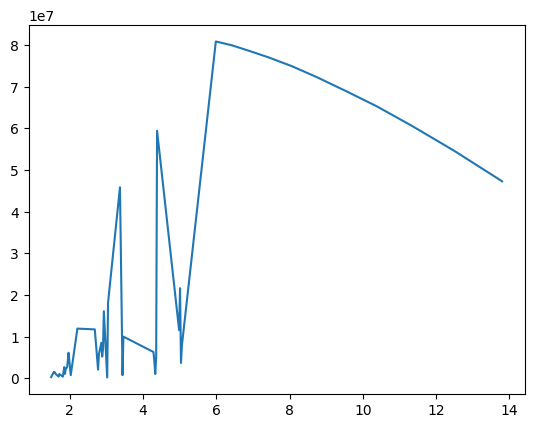

In [ ]:
# its a timing issue as not all GCs are at the same time step in regards to form and acc time
# thats why cumsum works.

type_flag = 0

time = plot_dict[it_id][str(type_flag)]["time"]
mass = plot_dict[it_id][str(type_flag)]["mass"]

plt.plot(time, mass)
# plt.yscale("log")

In [52]:
np.array(interim_dict[it_id][str(type_flag)]["mass"]).shape

(3550,)

In [56]:
interim_dict[it_id][str(type_flag)]["mass_loss"]

[0,
 5765.867176524965,
 216.45246134074023,
 209.58612524947512,
 329.9850589414291,
 352.576929166381,
 294.7774627024337,
 220.04893868107592,
 511.82614388251204,
 761.6844674566532,
 1576.8165331476898,
 1025.291285653643,
 1324.3415351946644,
 0,
 5236.547856996874,
 411.55064524325644,
 396.4327982381492,
 369.12170053329555,
 511.7118328364977,
 403.3302637224974,
 315.42873515668316,
 559.478933193046,
 902.7464615790341,
 765.0611864303326,
 1531.0874616820304,
 0,
 6544.396652917771,
 741.3537005393209,
 474.6069606496021,
 528.967725624243,
 740.3497966060877,
 715.2495093478574,
 1228.189023620228,
 1886.9704802784534,
 912.0108393559096,
 0,
 5789.653301968495,
 419.9229183162224,
 732.3391842171177,
 557.7998921184981,
 678.499759924096,
 894.9063874268204,
 1786.2489041475314,
 1025.651926251408,
 0,
 6691.633123566367,
 861.5113893054686,
 1014.0174521155986,
 1347.784390387631,
 1947.537603850852,
 2328.091257665008,
 0,
 6543.798404362079,
 130.00677026863195,
 169.2